In [1]:
! pip install pylibjpeg pylibjpeg-libjpeg pydicom
! pip install -U python-gdcm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 3.6 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 14.3 MB/s eta 0:00:0000:0100:01


<div style="color:white;display:fill;
            background-color: #A020F0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1 Libraries</b></p>
</div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cv2
import os
from os import listdir
import re
import gc
import gdcm
import pydicom
from pydicom import dcmread
import pylibjpeg
from pydicom.pixel_data_handlers.util import apply_voi_lut
import scipy.ndimage
from tqdm import tqdm
from pprint import pprint
from time import time
import itertools
from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
from glob import glob
import warnings
import dask.array as da
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses, callbacks
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image as im
from keras.models import load_model
from random import shuffle
import random
import tensorflow_hub as hub
%matplotlib inline
sns.set(style='darkgrid', font_scale=1.6)

<div style="color:white;display:fill;
            background-color: #A020F0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3 Data</b></p>
</div>


We need to load only the data of the patient present in bounding box csv. So, we will create a list of patient present in train_bounding_boxes.csv .

In [3]:
bounding_boxes=pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")

In [4]:
#Create a list of patient
patient=bounding_boxes["StudyInstanceUID"].unique()
len(patient)

235

In [5]:
#Loading Scans
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]

# Load the scans in given folder path
def load_scan(path):
    
    dcm_paths = glob(f"{path}/*")
    dcm_paths.sort(key=natural_keys)
    
    patient_scan = [pydicom.dcmread(paths) for paths in dcm_paths]
    
    return patient_scan

<div style="color:white;display:fill;
            background-color: #A020F0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4 Preprocessing</b></p>
</div>

<div style="color:white;display:fill;
            background-color: #A020F0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.1 Grayscale to RGB</b></p>
</div>

In [6]:
def gray_to_rgb(patient_scan):
    scan=[np.dstack([(0.6*255*patient_scan).astype('uint8'),(0.7*255*patient_scan).astype('uint8'),(0.9*255*patient_scan).astype('uint8')])]
    
    return scan

<div style="color:white;display:fill;
            background-color: #A020F0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.2 Loding and Conversion to HU</b></p>
</div>

In [7]:
def get_pixels_hu(slices):
   
    image = np.stack([cv2.resize(s.pixel_array,(512,512),interpolation = cv2.INTER_NEAREST) for s in slices])
    
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    image = da.from_array(image) #Using Dask to speed up processing
    
    # Convert to Hounsfield units (HU)
        
    intercept = da.from_array([slices[slice_number].RescaleIntercept for slice_number in range(len(slices))])
    slope = da.from_array([slices[slice_number].RescaleSlope for slice_number in range(len(slices))])
    
    intercept=intercept.reshape((-1,1,1))
    slope=slope.reshape((-1,1,1))
    
    image= slope * image.astype("float64")
        
    image+= intercept
     
    return image.astype("int16")

<div style="color:white;display:fill;
            background-color: #A020F0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.3 Normalization</b></p>
</div>

In [8]:
# https://radiopaedia.org/articles/windowing-ct
W=1800
L=400
def CT_windowing(image):
    image = (image-L+0.5*W)/W
    image[image<0] = 0
    image[image>1] = 1
    
    return image

<div style="color:white;display:fill;
            background-color: #A020F0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.4 Example</b></p>
</div>

In [9]:
#Example
image=load_scan("../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.9940")

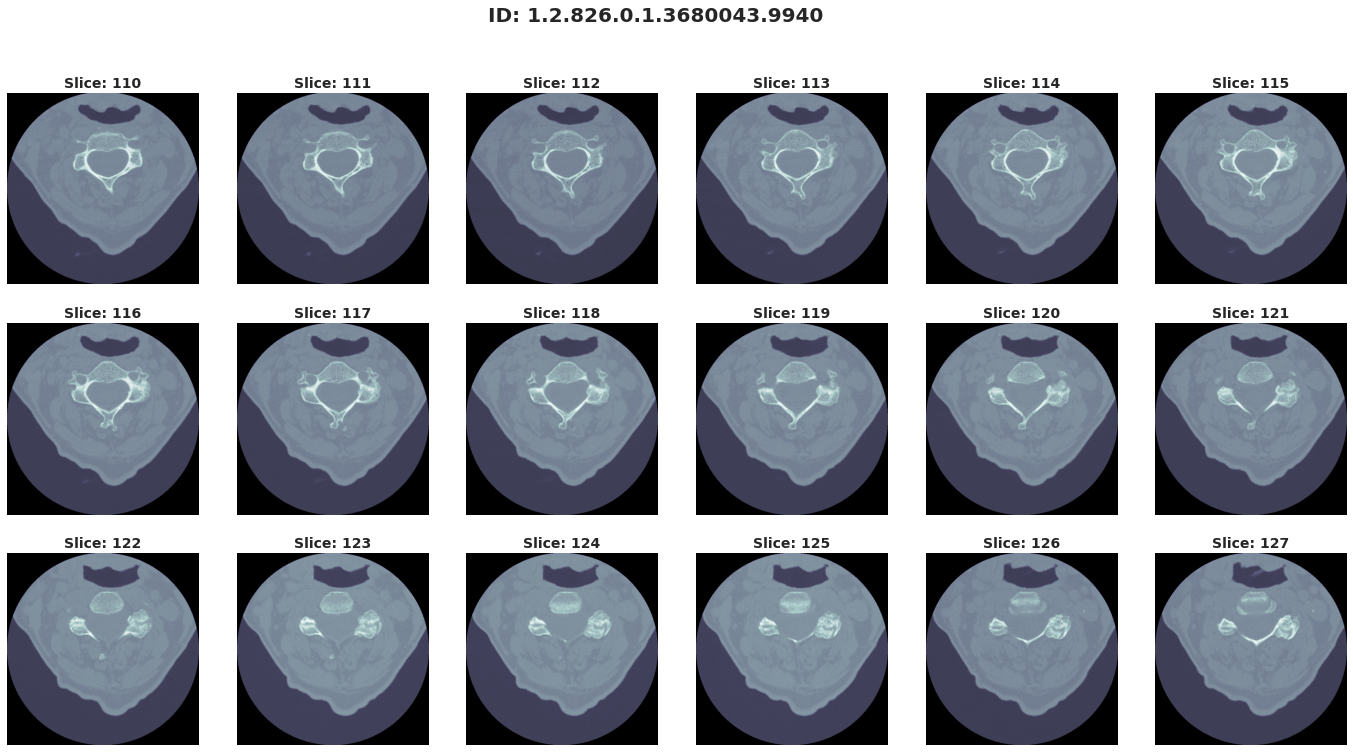

In [10]:
# Plot images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: 1.2.826.0.1.3680043.9940', weight="bold", size=20)

start = 110
for i in range(start,start+18):
    img = image[i].pixel_array
    slice_no = i

    # Plot the image
    x = (i-start) // 6
    y = (i-start) % 6

    axes[x, y].imshow(img, cmap="bone")
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

In [11]:
image=get_pixels_hu(image)

(-0.5, 511.5, 511.5, -0.5)

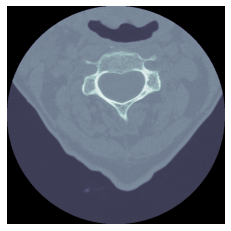

In [12]:
#Ploting HU array
plt.imshow(image[110],cmap='bone')
plt.axis("off")

In [13]:
image=CT_windowing(image)

(-0.5, 511.5, 511.5, -0.5)

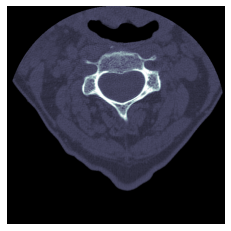

In [14]:
#Ploting HU array
plt.imshow(image[110],cmap="bone")
plt.axis("off")

In [15]:
del image, img
del fig, axes

gc.collect()

42404

<div style="color:white;display:fill;
            background-color: #A020F0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>5 Model</b></p>
</div>

In [16]:
def model_CNN(model_handle):
    model=tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(512,512,3)),
                              hub.KerasLayer(model_handle, trainable=False),
                               
                              tf.keras.layers.Dense(512,activation="relu"),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.3),
                               
                              tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1_l2(0.0001),activation="sigmoid")])
    model.build([None, 512, 512, 3])
    print(model.summary())
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
    
    return model

In [17]:
X_train_patient, X_Val_patient = train_test_split(patient,train_size=188,test_size=46,shuffle=True)

In [18]:
#Calculate the size of dataset and create a list of IDs for all the images
def findSize(patient_ID):
    image_ID=[]
    for ID in tqdm(patient_ID):
        scan=load_scan(f"../input/rsna-2022-cervical-spine-fracture-detection/train_images/{ID}")
        for i in range(1,len(scan)+1):
            image_ID.append(ID+"/"+str(i))
        
        del scan
        gc.collect()
    
    return len(image_ID),image_ID

In [19]:
train_Size,train_X=findSize(X_train_patient)
gc.collect()

Val_Size,Val_X=findSize(X_Val_patient)
gc.collect()

100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


0

In [20]:
print(train_Size)
print(Val_Size)

61795
15603


In [21]:
#https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(keras.utils.Sequence):
    def __init__(self,list_IDs,batch_size=64,dim_X=(512,512),dim_Y=(1,),n_channels=3,shuffle=True):
        
        self.dim_X=dim_X
        self.dim_Y=dim_Y
        self.batch_size=batch_size
        self.list_IDs=list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
    
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        data = self.__data_generation(list_IDs_temp)

        return data.next()
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        
        X = np.empty((self.batch_size, *self.dim_X, self.n_channels))
        y = np.empty((self.batch_size, *self.dim_Y))
        
        # Generate data
        for i,ID in enumerate(list_IDs_temp):
                
            # Store sample
            
            try:
                #Loading a image
                image = pydicom.dcmread(f"../input/rsna-2022-cervical-spine-fracture-detection/train_images/{ID}.dcm")
            
                #Conversion to HU
                image_array = cv2.resize(image.pixel_array,(512,512),interpolation = cv2.INTER_NEAREST)
                image_array = image_array.astype(np.int16)
                image_array = da.from_array(image_array)
                image_array = image.RescaleSlope * image_array.astype("float64")
                image_array += image.RescaleIntercept
                image_array = image_array.astype("int16")
            
                #CT Windowing
                image_array = CT_windowing(image_array)
            
                #Grayscale to RGB
                image_array=gray_to_rgb(image_array)
            
                X[i,] = da.array(image_array).astype(np.uint8)
            
            
                # Store class
            
                #Loading Fractured slice
                temp_lables=np.zeros(1)
                if i+1 in bounding_boxes[bounding_boxes["StudyInstanceUID"]==ID.split("/")[0]]["slice_number"]:
                    temp_lables[0]=1
                    
                y[i,] = temp_lables.astype(np.uint8)
            
                del temp_lables , image, image_array
                gc.collect()
                
            except:
                continue
            
        #Data augmentation
        datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # dimesion reduction
                rotation_range=5,  # randomly rotate images in the range 5 degrees
                zoom_range = 0.1, # Randomly zoom image 10%
                width_shift_range=0.1,  # randomly shift images horizontally 10%
                height_shift_range=0.1,  # randomly shift images vertically 10%
                horizontal_flip=True,  # randomly flip images
                vertical_flip=True)  # randomly flip images
            
        datagen.fit(X)
        data=datagen.flow(X,y)
        
        return data

In [22]:
training_generator = DataGenerator(train_X, batch_size=5,  dim_X=(512,512), dim_Y=(1,), n_channels=3, shuffle=True)
validation_generator = DataGenerator(Val_X, batch_size=3,  dim_X=(512,512), dim_Y=(1,), n_channels=3, shuffle=True)

In [23]:
def fit(model):
    
    early_stopping = callbacks.EarlyStopping(
        min_delta=0.001, # minimium amount of change to count as an improvement
        patience=5, # how many epochs to wait before stopping
        restore_best_weights=True,
    )
    
    history=model.fit(training_generator,epochs=50,shuffle=True,callbacks=[early_stopping],validation_data=validation_generator,steps_per_epoch=400,validation_steps=200,workers=2,use_multiprocessing=True)
    
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot();
    print("Minimum validation loss: {}".format(history_df['val_loss'].min()))
    
    model.save("Detector.h5")

2022-09-26 05:31:01.086830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 05:31:01.106204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 05:31:01.107006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 05:31:01.108835: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              207615832 
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 208,274,265
Trainable params: 657,409
Non-trainable params: 207,616,856
_________________________________________________________________
None


2022-09-26 05:31:34.094393: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-09-26 05:32:12.505379: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


400/400 [==============================] - 1793s 4s/step - loss: 0.0818 - accuracy: 0.9960 - val_loss: 0.1721 - val_accuracy: 0.9767
Epoch 2/50
400/400 [==============================] - 1762s 4s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.1417 - val_accuracy: 0.9833
Epoch 3/50
400/400 [==============================] - 1781s 4s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1558 - val_accuracy: 0.9817
Epoch 4/50
400/400 [==============================] - 1773s 4s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2432 - val_accuracy: 0.9750
Epoch 5/50
400/400 [==============================] - 1803s 4s/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 7.3426 - val_accuracy: 0.9750
Epoch 6/50
400/400 [==============================] - 1776s 4s/step - loss: 7.7939e-04 - accuracy: 1.0000 - val_loss: 9.6052 - val_accuracy: 0.9883
Epoch 7/50
400/400 [==============================] - 1765s 4s/step - loss: 6.6445e-04 - accuracy: 1.0000 - val_loss: 0.2219 - val_accuracy: 0.

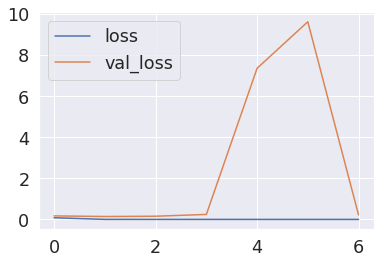

In [24]:
fit(model_CNN("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2"))